# A pin cell from the Mosteller suite

## Imports

In [1]:
%load_ext wurlitzer

In [2]:
from tripoli5.core.euclide import Direction, Point
from tripoli5.core.physics import ParticleType
from tripoli5.core.literals import K, MeV
import tripoli5

In [3]:
title = "Mosteller pin cell"

## Geometry

First, we define the basic shapes and universes. The fuel rod lives in an infinite universe, which we use to fill the unit pin cell.

In [4]:
c_fuel = tripoli5.agora.ZCylinder(0.0, 0.0, 0.39398)
s_fuel = tripoli5.agora.Shape(-c_fuel)
v_fuel = tripoli5.agora.Volume(s_fuel, "FUEL", label="FUEL")

c_gap = tripoli5.agora.ZCylinder(0.0, 0.0, 0.40226)
s_gap = tripoli5.agora.Shape(c_fuel & -c_gap)
v_gap = tripoli5.agora.Volume(s_gap, "GAP", label="GAP")

c_clad = tripoli5.agora.ZCylinder(0.0, 0.0, 0.45972)
s_clad = tripoli5.agora.Shape(c_gap & -c_clad)
v_clad = tripoli5.agora.Volume(s_clad, "ZIRCALLOY", label="ZIRCALLOY")

s_water = tripoli5.agora.Shape(c_clad)
v_water = tripoli5.agora.Volume(s_water, "WATER", label="WATER")

u_cell = tripoli5.agora.Universe([v_fuel, v_gap, v_clad, v_water])

pin_pitch = 2.0 * 0.63339
px_lo = tripoli5.agora.XPlane(-0.5 * pin_pitch)
px_hi = tripoli5.agora.XPlane(0.5 * pin_pitch)
py_lo = tripoli5.agora.YPlane(-0.5 * pin_pitch)
py_hi = tripoli5.agora.YPlane(0.5 * pin_pitch)
pz_lo = tripoli5.agora.ZPlane(-10.0)
pz_hi = tripoli5.agora.ZPlane(10.0)
r_cell = px_lo & -px_hi & py_lo & -py_hi & pz_lo & -pz_hi
s_cell = tripoli5.agora.Shape(r_cell)

v_cell = tripoli5.agora.CompositeVolume(s_cell, filler=u_cell, label="CELL")
v_outside = tripoli5.agora.Volume.outside(tripoli5.agora.Shape(-r_cell))

root_universe = tripoli5.agora.Universe([v_cell, v_outside])

Now we need to apply boundary conditions to the six planes of the pin cell. Note that we need to specify the universe and the traversal direction (from negative to positive, or from positive to negative) for which we want the boundary conditions to apply. In other words, the boundary condition will apply only to particles traversing the given surface, in the given universe, in the given direction.  
Note also that only one boundary condition is allowed on each surface-universe pair.

In [5]:
bcs = tripoli5.agora.BoundaryConditions()
reflection_bc = tripoli5.agora.ReflectionBoundaryCondition()
for p in px_lo, py_lo, pz_lo:
    bcs.add(root_universe, p, tripoli5.agora.SurfaceCrossing.ToNegative, reflection_bc)
for p in px_hi, py_hi, pz_hi:
    bcs.add(root_universe, p, tripoli5.agora.SurfaceCrossing.ToPositive, reflection_bc)

Finally, we associate the boundary conditions to the geometry.

In [6]:
geo = tripoli5.agora.Geometry(root_universe, boundary_conditions=bcs)

## Plotting the geometry


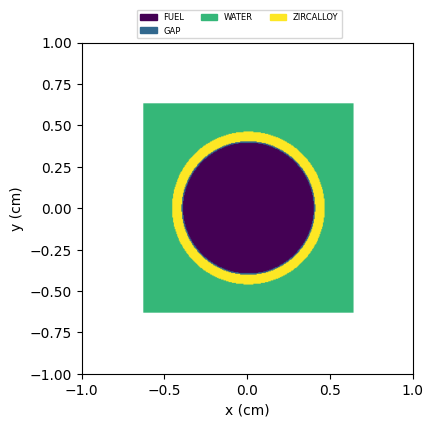

In [7]:
plotter = tripoli5.geoplotter.GeoPlotterPyplot(geo)

frame = tripoli5.geoplotter.Frame.fromMinMax(
    "XY", altitude=0.0, u_min=-1, u_max=1, v_min=-1, v_max=1
)
_ = plotter.plot(frame=frame, resolution=200)

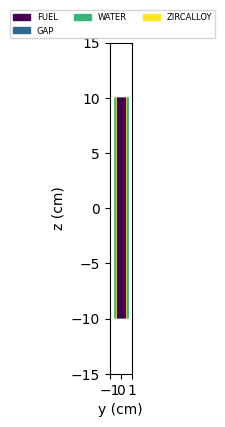

In [8]:
frame = tripoli5.geoplotter.Frame.fromMinMax(
    "YZ", altitude=0.0, u_min=-1, u_max=1, v_min=-15, v_max=15
)
_ = plotter.plot(frame=frame, resolution=200)

## Nuclear Data and Material Compositions

In [9]:
catalog = tripoli5.delos.Catalog.fromFile(
    f"/opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v{tripoli5.delos.CATALOG_VERSION}.yaml"
)

[2025-10-07 12:09:22.323] [info] Loading catalog from file: /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/endfb8r0_mcnp_v2.2.0.yaml


Creates `mixtures`, i.e. material compositions, using the `MixtureBuilder`

In [10]:
m_fuel = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName("FUEL")
    .withCatalog(catalog)
    .withTemperature(600.0 * K)
    .add("O16", 0.0461297)
    .add("U234", 5.81576e-06)
    .add("U235", 0.000723867)
    .add("U238", 0.0223352)
    .build()
)

m_gap = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName("GAP")
    .withCatalog(catalog)
    .withTemperature(600.0 * K)
    .add("HE4", 1e-16)
    .build()
)

m_clad = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName("ZIRCALLOY")
    .withCatalog(catalog)
    .withTemperature(600.0 * K)
    .add("ZR90", 0.0217035651)
    .add("ZR91", 0.00473302236)
    .add("ZR92", 0.0072345217)
    .add("ZR94", 0.00733154444)
    .add("ZR96", 0.0011811464)
    .build()
)

m_water = (
    tripoli5.materials.MixtureBuilder("concentrations")
    .withName("WATER")
    .withCatalog(catalog)
    .withTemperature(600.0 * K)
    .add("H1_H2O", 4.42326e-2)
    .add("B10", 1.02133e-5)
    .add("B11", 4.11098e-5)
    .add("O16", 2.21163e-2)
    .build()
)

mixtures = [m_fuel, m_gap, m_clad, m_water]

for mix in mixtures:
    mix.printSummary()

[2025-10-07 12:09:22.353] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-10-07 12:09:22.362] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-10-07 12:09:22.365] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-10-07 12:09:22.368] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/mass/njoy_ace/v0.2.0/archive/wrapped_mass_data.bin
[2025-10-07 12:09:22.371] [info] Mixture: FUEL
[2025-10-07 12:09:22.371] [info] Temperature field:  Temperature is: 600 [K], 5.17039944e-08 [MeV], 326.85 [°C]

[2025-10-07 12:09:22.371] [info] === Owning mixture composition: ===Number of IDs: 1Number of nuclides: 4IDs: O16 U234 U235 U2380 0.0461297 5.81576e-06 0.000723867 0.0223352

[2025-10-07 12:09:22.371] [info] Mixture: GAP
[2025-10-07 12:09:22.371] [info] Temperature field:  Temperature is: 600 [K], 5

In [11]:
media = (
    tripoli5.materials.NeutronMediumBuilder()
    .withCatalog(catalog)
    .withMixtures(mixtures)
    .build()
)

[2025-10-07 12:09:22.383] [info] Building B10 at temperatures: TemperatureRange(600 [K], 5.17039944e-08 [MeV], 326.85 [°C])
[2025-10-07 12:09:22.384] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/B10.600.bin
[2025-10-07 12:09:22.387] [info]   Building free gas collisions at temperature 600 [K], 5.17039944e-08 [MeV], 326.85 [°C]
[2025-10-07 12:09:22.387] [info]   Building reaction MTs = 700, 51, 57, 58, 60, 59, 77, 79, 80, 56, 85, 78, 52, 81, 801, 800, 104, 102, 68, 601, 70, 600, 69, 602, 71, 53, 82, 604, 73, 83, 113, 54, 605, 74, 75, 76, 67, 66, 65, 64, 63, 62, 61, 2, 72, 603, 84, 55
[2025-10-07 12:09:22.387] [info] Building B11 at temperatures: TemperatureRange(600 [K], 5.17039944e-08 [MeV], 326.85 [°C])
[2025-10-07 12:09:22.388] [info] Loading /opt/tripoli-5/delos/nuclide/endfb8r0_mcnp/freegas/njoy_ace/v0.11.0/dir/B11.600.bin
[2025-10-07 12:09:22.391] [info]   Building free gas collisions at temperature 600 [K], 5.17039944e-08 [MeV], 326.85 [°

## Sources


Define a source that is:  

- isotropic
- point (0.,0.,0.)
- 2 MeV incident energy

In [12]:
src = tripoli5.source.PointIsotropicSource(
    ParticleType("Neutron"),
    tripoli5.distributions.energy.MonoKinetic(2.0 * MeV),
    Point(0.0, 0.0, 0.0),  # point source
    1.0,  # norm
    0.0,  # time
)

## Score

Define a flux score over an energy grid of 1000 groups defined with equivalent bins in lethargy. 

In [13]:
score_mgr = tripoli5.score.ScoreManager(title)
flux = tripoli5.score.FluxSpectrumAllVolumes(
    1, 1e-11, 20.0, 1000, "FluxSpectrumAllVolumes"
)
score_mgr.addScore(flux)

## Simulation setup

Simulation parameters 

In [14]:
simu_params = tripoli5.simulation.SimulationParameters(
    nb_cycles=120,
    nb_events=10000,
    nb_threads=10,
    name=title,
    discard=10,
)
print(f"{simu_params.name=}")
print(f"{simu_params.nb_threads=}")
print(f"{simu_params.nb_cycles=}")
print(f"{simu_params.nb_events=}")
print(f"{simu_params.discard=}")

simu_params.name='Mosteller pin cell'
simu_params.nb_threads=10
simu_params.nb_cycles=120
simu_params.nb_events=10000
simu_params.discard=10


## Launching the code

In [15]:
simu = (
    tripoli5.simulation.SimulationBuilder(
        simulation_mode="criticality", parallelism_type="openmp"
    )
    .withSource(src)
    .withGeometry(geo)
    .withMedia("Neutron", media)
    .withParameters(simu_params)
    .withScores(score_mgr)
    .build()
)

Running the simulation 

In [16]:
simu.run()

[2025-10-07 12:09:22.623] [info] *** Beginning of simulation ***
[2025-10-07 12:09:22.631] [info] Cycle: 1 of 120
[2025-10-07 12:09:23.271] [info]   kstep = 1.18700
[2025-10-07 12:09:23.271] [info]   Mean number of collisions: 28.6090
[2025-10-07 12:09:23.272] [info] Cycle: 2 of 120
[2025-10-07 12:09:23.731] [info]   kstep = 1.17540
[2025-10-07 12:09:23.731] [info]   Mean number of collisions: 28.6182
[2025-10-07 12:09:23.732] [info] Cycle: 3 of 120
[2025-10-07 12:09:24.211] [info]   kstep = 1.18550
[2025-10-07 12:09:24.211] [info]   Mean number of collisions: 28.5651
[2025-10-07 12:09:24.213] [info] Cycle: 4 of 120
[2025-10-07 12:09:24.692] [info]   kstep = 1.16260
[2025-10-07 12:09:24.692] [info]   Mean number of collisions: 28.4156
[2025-10-07 12:09:24.694] [info] Cycle: 5 of 120
[2025-10-07 12:09:25.182] [info]   kstep = 1.17050
[2025-10-07 12:09:25.182] [info]   Mean number of collisions: 28.2822
[2025-10-07 12:09:25.184] [info] Cycle: 6 of 120
[2025-10-07 12:09:25.665] [info]   k

## Inspecting results

### k<sub>eff</sub>

In [17]:
import numpy as np

kstep = simu.getKStep()
t5_kstep_mean = kstep.mean[0]
t5_kstep_var = kstep.var[0]
t5_kstep_sigma = np.sqrt(t5_kstep_var)
print(f"TRIPOLI-5: k_step = {t5_kstep_mean:.5f} ± {t5_kstep_sigma:.5f}")

TRIPOLI-5: k_step = 1.17540 ± 0.00114


Here are the reference TRIPOLI-4 results:

In [18]:
t4_kstep_mean = 1.177819e00
# T4 expresses standard errors as relative values, in percent
t4_kstep_sigma = 1.027623e-01 * 1e-2 * t4_kstep_mean
t4_kstep_var = t4_kstep_sigma**2

print(f"TRIPOLI-4: k_step = {t4_kstep_mean:.5f} ± {t4_kstep_sigma:.5f}")

TRIPOLI-4: k_step = 1.17782 ± 0.00121


The TRIPOLI-4/TRIPOLI-5 comparison passes Student's t-test:

In [19]:
t_student = (t5_kstep_mean - t4_kstep_mean) / np.sqrt(t5_kstep_var + t4_kstep_var)
print(f"{t_student = :.2f}")
assert np.abs(t_student) < 3.0

t_student = -1.46
